In [2]:
import os
import sys
WD = "/Users/niche/OneDrive - Virginia Tech/_06_Mautushi/Pi-Computer-Vision"
os.chdir(WD)
sys.path.append(WD)

# native imports
import matplotlib.pyplot as plt
import numpy as np
import json
# local imports
from models.models import init_model, get_labels, get_features_ext

# torch imports
from datasets import load_dataset
from torchvision.transforms import ColorJitter
import torch
import torch.nn as nn
# transformer
from transformers import DetrFeatureExtractor, DetrForSegmentation, DetrConfig


### Cow50

In [3]:
ds = load_dataset(os.path.join("data", "cow50", "data.py"), split="train")
ds = ds.train_test_split(test_size=0.2)

Found cached dataset data (/Users/niche/.cache/huggingface/datasets/data/Cow50/1.0.0/77797b90b771e329452083e3f9eaad44a8bbf13a5a7e7c62ca8fbbdd27a64cac)


In [4]:
print(ds)

DatasetDict({
    train: Dataset({
        features: ['image', 'annotation'],
        num_rows: 40
    })
    test: Dataset({
        features: ['image', 'annotation'],
        num_rows: 10
    })
})


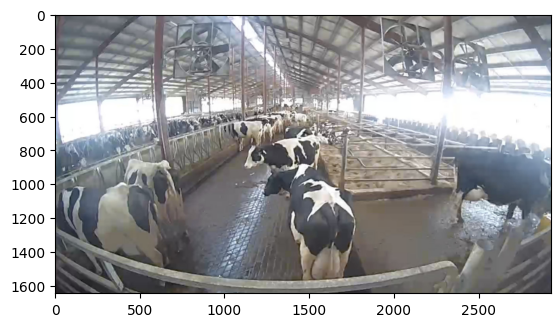

In [5]:
image = ds["train"][0]["image"]
image = np.array(image)
plt.imshow(image)

## DETR

In [6]:
MODELNAME = "facebook/detr-resnet-50-panoptic"
model = DetrForSegmentation.from_pretrained(MODELNAME)
model

DetrForSegmentation(
  (detr): DetrForObjectDetection(
    (model): DetrModel(
      (backbone): DetrConvModel(
        (conv_encoder): DetrTimmConvEncoder(
          (model): FeatureListNet(
            (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            (bn1): DetrFrozenBatchNorm2d()
            (act1): ReLU(inplace=True)
            (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
            (layer1): Sequential(
              (0): Bottleneck(
                (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (bn1): DetrFrozenBatchNorm2d()
                (act1): ReLU(inplace=True)
                (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn2): DetrFrozenBatchNorm2d()
                (drop_block): Identity()
                (act2): ReLU(inplace=True)
                (aa): Identity()
                (conv

In [18]:
class_map = {
    "no_object": 0,
    "cow": 1
}
feature_extractor = DetrFeatureExtractor.from_pretrained(
    MODELNAME,
    size=224,
    format="coco_panoptic",
    class_map=class_map
)
# Create a config object
config = DetrConfig.from_pretrained(
    MODELNAME,
    num_labels=1
)

In [20]:
model.detr.class_labels_classifier = nn.Linear(model.config.hidden_size, 2)

# Remove the classifier weights and bias from the state dict
state_dict = model.state_dict()
state_dict.keys()
state_dict.pop("detr.class_labels_classifier.weight")
state_dict.pop("detr.class_labels_classifier.bias")
# # Load the state dict into the model
model.load_state_dict(state_dict, strict=False)
# Assign the config object to the model config
model.config = config

In [21]:
feature_extractor

DetrFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "DetrFeatureExtractor",
  "format": "coco_panoptic",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "max_size": 1333,
  "size": 224
}

### Enconding

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


original shape:  (720, 1280, 3)
keys:  dict_keys(['pixel_values', 'pixel_mask'])
feature shape:  torch.Size([3, 750, 1333])
label:  torch.Size([750, 1333])


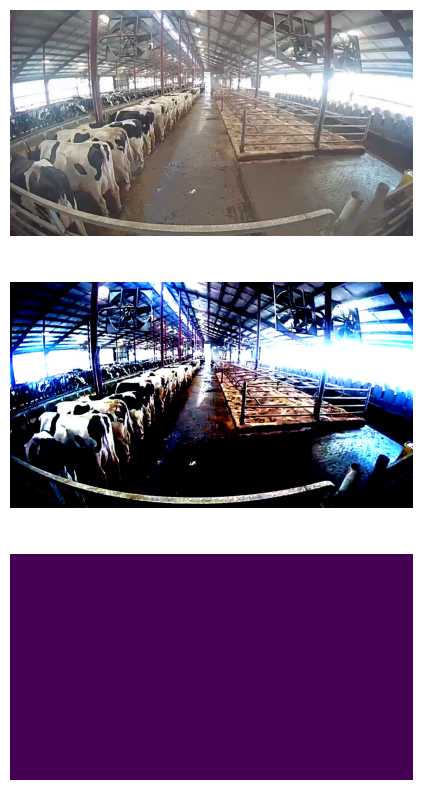

In [38]:
feature_extractor = get_features_ext(MODELNAME)
encoding = feature_extractor(image, return_tensors="pt")
fig, axs = plt.subplots(3, 1, figsize=(10, 10))
axs[0].imshow(image)
axs[1].imshow(encoding.pixel_values[0].permute(1, 2, 0))
axs[2].imshow(encoding.pixel_mask[0])
for ax in axs:
    ax.axis("off")

print("original shape: ", np.array(image).shape)
print("keys: ", encoding.keys())
print("feature shape: ", encoding.pixel_values[0].shape)
print("label: ", encoding.pixel_mask[0].shape)

In [127]:
outputs = model(**encoding)

In [125]:
type(model)
# https://github.com/huggingface/transformers/blob/v4.20.0/src/transformers/models/detr/modeling_detr.py

transformers.models.detr.modeling_detr.DetrForSegmentation

In [132]:
list(outputs)
logits = outputs["logits"][0].detach().numpy()
pred_boxes = outputs["pred_boxes"][0].detach().numpy()
pred_masks = outputs["pred_masks"][0].detach().numpy()

(100, 251)


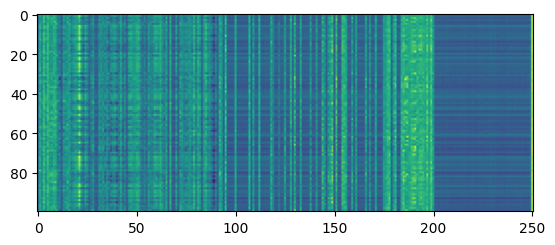

In [133]:
print(logits.shape)
plt.imshow(logits)

In [188]:
# get classified labels
lbs = np.argmax(logits, axis=1)
print(lbs)
det_i = np.where(lbs != 250)[0]
print(det_i)
lod = logits[det_i, lbs[det_i]]
print(lod)
np.array(lod > 10).sum()

[250  21 250 250 250 250  21 250 250 250 250 250  21 250 250 250 250 250
 250 250  21 130  21 250 250  21  21 250 250  21 250 250 250 186 250 250
 250 250 250 250 250  21  21  21 250 250 250  21  21 250 250  21 250 250
 250 250 250 250 250 250 250  21 187 250 250  21 250 191 250 250  21 250
  21  21  21 250  21 250 250 250 250 250 250 250 250 250 250  21 250 250
  21 250  21 250 250 149 250 250 250 250]
[ 1  6 12 20 21 22 25 26 29 33 41 42 43 47 48 51 61 62 65 67 70 72 73 74
 76 87 90 92 95]
[ 9.278169 11.11533  11.087131 10.890488  9.626924 10.767478 11.557853
  9.875607  9.404809 14.278185  9.916222  9.963456  8.699222 10.110696
 10.984822 12.062049 10.042461 11.594709 10.253496 11.401279  9.405596
 12.891759 10.566669 10.035477  9.66623  10.452255 11.17315  10.847889
 11.065597]


20

In [62]:
outputs["logits"][0]

tensor([[-15.7782,  -2.3883,  -7.6673,  ..., -15.0952, -14.9441,   9.8220],
        [-13.4134,   0.4461,  -6.9648,  ..., -13.2376, -13.2139,   9.2413],
        [-15.1243,  -5.2724,  -7.1162,  ..., -14.9551, -16.3355,  10.0760],
        ...,
        [-15.2302,   0.8764,  -7.2576,  ..., -14.7225, -14.8060,   7.9061],
        [-15.2939,  -2.1489,  -6.7219,  ..., -14.4210, -15.2877,   8.7071],
        [-15.1370,  -1.7930,  -5.1032,  ..., -15.3074, -15.3957,   9.9235]],
       grad_fn=<SelectBackward0>)

In [41]:
outputs["pred_boxes"].shape

torch.Size([1, 100, 4])

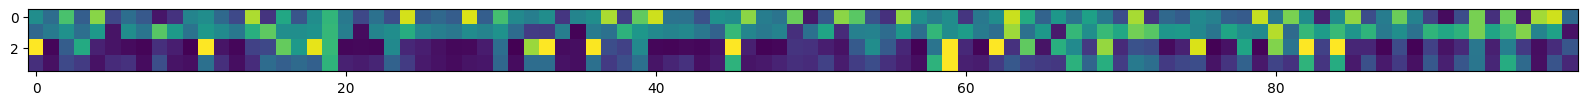

In [161]:
plt.figure(figsize=(20, 10))
plt.imshow(pred_boxes.transpose())

In [33]:
outputs["pred_masks"].shape

torch.Size([1, 100, 188, 334])

[0.41028297 0.42645058 0.03009244 0.09015149]


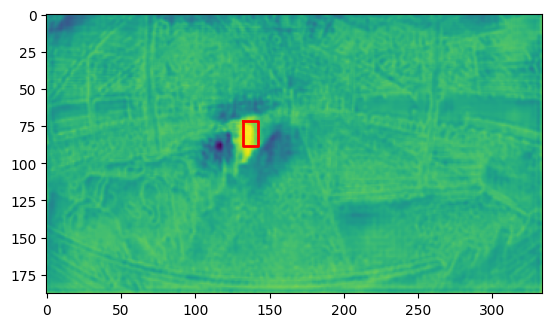

In [240]:
i = det_i[16]
imgH, imgW = pred_masks[i].shape[:2]
plt.imshow(pred_masks[i])
# draw the box
print(pred_boxes[i])
cx = pred_boxes[i][0]
cy = pred_boxes[i][1]
w = pred_boxes[i][2]
h = pred_boxes[i][3]
x = cx - w/2
y = cy - h/2
ptx = np.array([x, x + w, x + w, x, x]) * imgW
pty = np.array([y, y, y + h, y + h, y]) * imgH
plt.plot(ptx, pty, color="red", linewidth=2)

In [35]:
outputs["last_hidden_state"].shape

torch.Size([1, 100, 256])

In [201]:
import io
from transformers.models.detr.feature_extraction_detr import rgb_to_id
from PIL import Image

processed_sizes = torch.as_tensor(image.shape[:2]).unsqueeze(0)
print(processed_sizes)
result = feature_extractor.post_process_panoptic(outputs, processed_sizes)[0]
# the segmentation is stored in a special-format png
panoptic_seg = Image.open(io.BytesIO(result["png_string"]))
panoptic_seg = np.array(panoptic_seg, dtype=np.uint8)
# retrieve the ids corresponding to each mask
pred_seg = rgb_to_id(panoptic_seg)
result["segments_info"]

tensor([[ 720, 1280]])


/Users/niche/miniforge3/envs/tf/lib/python3.9/site-packages/transformers/models/detr/feature_extraction_detr.py:996: FutureWarning: `post_process_panoptic is deprecated and will be removed in v5 of Transformers, please use `post_process_panoptic_segmentation`.
  warnings.warn(


[{'id': 0, 'isthing': True, 'category_id': 21, 'area': 3026},
 {'id': 1, 'isthing': True, 'category_id': 21, 'area': 2156},
 {'id': 2, 'isthing': True, 'category_id': 21, 'area': 1118},
 {'id': 3, 'isthing': True, 'category_id': 21, 'area': 1168},
 {'id': 4, 'isthing': True, 'category_id': 21, 'area': 4088},
 {'id': 5, 'isthing': False, 'category_id': 186, 'area': 799683},
 {'id': 6, 'isthing': True, 'category_id': 21, 'area': 1820},
 {'id': 7, 'isthing': True, 'category_id': 21, 'area': 10191},
 {'id': 8, 'isthing': True, 'category_id': 21, 'area': 70244},
 {'id': 9, 'isthing': True, 'category_id': 21, 'area': 4513},
 {'id': 10, 'isthing': True, 'category_id': 21, 'area': 2615},
 {'id': 11, 'isthing': True, 'category_id': 21, 'area': 20978}]

[{'id': 1, 'label_id': 21, 'was_fused': False, 'score': 0.50789}, {'id': 2, 'label_id': 21, 'was_fused': False, 'score': 0.95263}, {'id': 3, 'label_id': 21, 'was_fused': False, 'score': 0.905285}, {'id': 4, 'label_id': 21, 'was_fused': False, 'score': 0.956334}, {'id': 5, 'label_id': 186, 'was_fused': False, 'score': 0.98701}, {'id': 6, 'label_id': 21, 'was_fused': False, 'score': 0.529822}, {'id': 7, 'label_id': 21, 'was_fused': False, 'score': 0.793569}, {'id': 8, 'label_id': 21, 'was_fused': False, 'score': 0.907166}, {'id': 9, 'label_id': 21, 'was_fused': False, 'score': 0.985219}, {'id': 10, 'label_id': 187, 'was_fused': False, 'score': 0.685682}, {'id': 11, 'label_id': 191, 'was_fused': False, 'score': 0.810236}, {'id': 12, 'label_id': 21, 'was_fused': False, 'score': 0.986651}, {'id': 13, 'label_id': 21, 'was_fused': False, 'score': 0.890373}, {'id': 14, 'label_id': 21, 'was_fused': False, 'score': 0.720434}, {'id': 15, 'label_id': 21, 'was_fused': False, 'score': 0.854391}, {'i

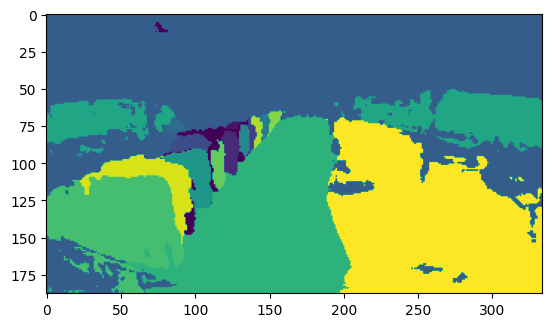

In [224]:
import io
from transformers.models.detr.feature_extraction_detr import rgb_to_id
from PIL import Image

result = feature_extractor.post_process_panoptic_segmentation(outputs, overlap_mask_area_threshold=.5)[0]
print(result["segments_info"])
plt.imshow(result["segmentation"])

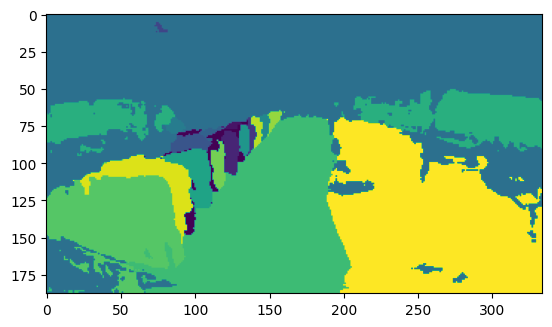

In [199]:
result["segments_info"]

[{'id': 1, 'label_id': 21, 'was_fused': False, 'score': 0.95263},
 {'id': 2, 'label_id': 21, 'was_fused': False, 'score': 0.956334},
 {'id': 3, 'label_id': 186, 'was_fused': False, 'score': 0.98701},
 {'id': 4, 'label_id': 21, 'was_fused': False, 'score': 0.529822},
 {'id': 5, 'label_id': 21, 'was_fused': False, 'score': 0.985219},
 {'id': 6, 'label_id': 187, 'was_fused': False, 'score': 0.685682},
 {'id': 7, 'label_id': 191, 'was_fused': False, 'score': 0.810236},
 {'id': 8, 'label_id': 21, 'was_fused': False, 'score': 0.986651},
 {'id': 9, 'label_id': 21, 'was_fused': False, 'score': 0.720434},
 {'id': 10, 'label_id': 149, 'was_fused': False, 'score': 0.719688}]

In [ ]:
# the segmentation is stored in a special-format png
panoptic_seg = Image.open(io.BytesIO(result["png_string"]))
panoptic_seg = np.array(panoptic_seg, dtype=np.uint8)
# retrieve the ids corresponding to each mask
pred_seg = rgb_to_id(panoptic_seg)

In [47]:
pred_seg.shape

(720, 1280)

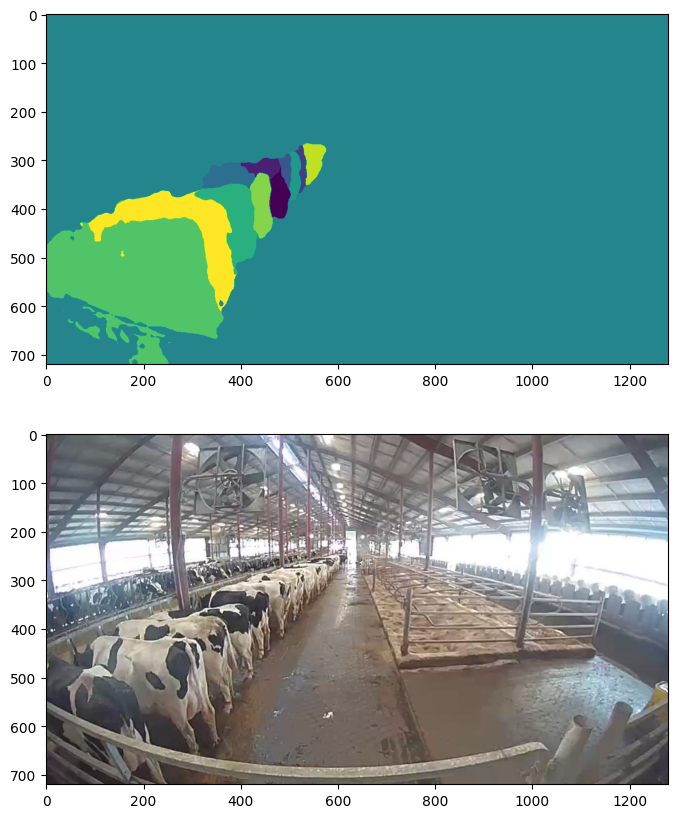

In [51]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].imshow(pred_seg)
axs[1].imshow(image)